In [1]:
from utils.gcps import (
    compute_error,
    gcp_geobox,
    mk_error_plot,
    review_sample,
    rio_gcp_transformer,
    sub_sample,
    to_pandas,
)
from utils.zict import open_zict_json

In [2]:
samples = open_zict_json("Data/emit-xyz-samples.zip", "r")
stacs = open_zict_json("Data/emit-stac.zip", "r")
all_ids = list(samples)
len(all_ids), all_ids[:5]

(52813,
 ['EMIT_L2A_RFL_001_20220810T034226_2222203_008',
  'EMIT_L2A_RFL_001_20220810T034759_2222203_015',
  'EMIT_L2A_RFL_001_20220810T034724_2222203_012',
  'EMIT_L2A_RFL_001_20220810T051030_2222204_002',
  'EMIT_L2A_RFL_001_20220810T034103_2222203_001'])

### Load Sample Data

In [3]:
granule = "EMIT_L2A_RFL_001_20230316T045133_2307503_005"  # AU
# granule = "EMIT_L2A_RFL_001_20230531T133036_2315109_002"  # Gibraltar
#granule = "EMIT_L2A_RFL_001_20230804T142809_2321610_001"  # South America
#granule = all_ids[20_106]

sample = samples[granule]
doc = stacs[granule]
print(f"Granule {granule}, {sample['shape'][1]}x{sample['shape'][0]}px")

#_ = review_sample(_sample, figsize=(7, 5), s=90)

Granule EMIT_L2A_RFL_001_20230316T045133_2307503_005, 1242x2176px


### GCP Error Analysis: whole

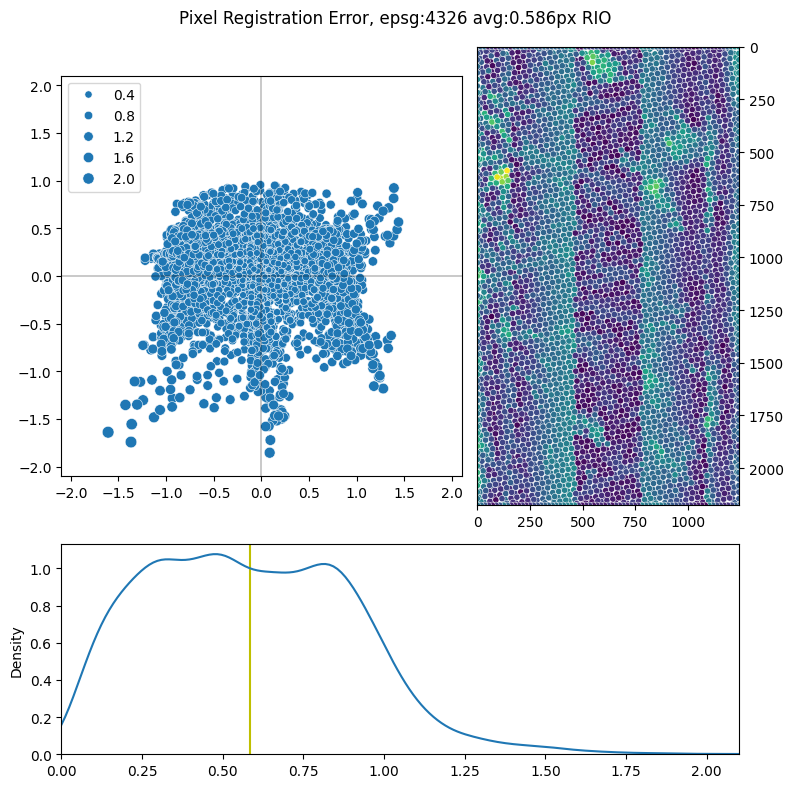

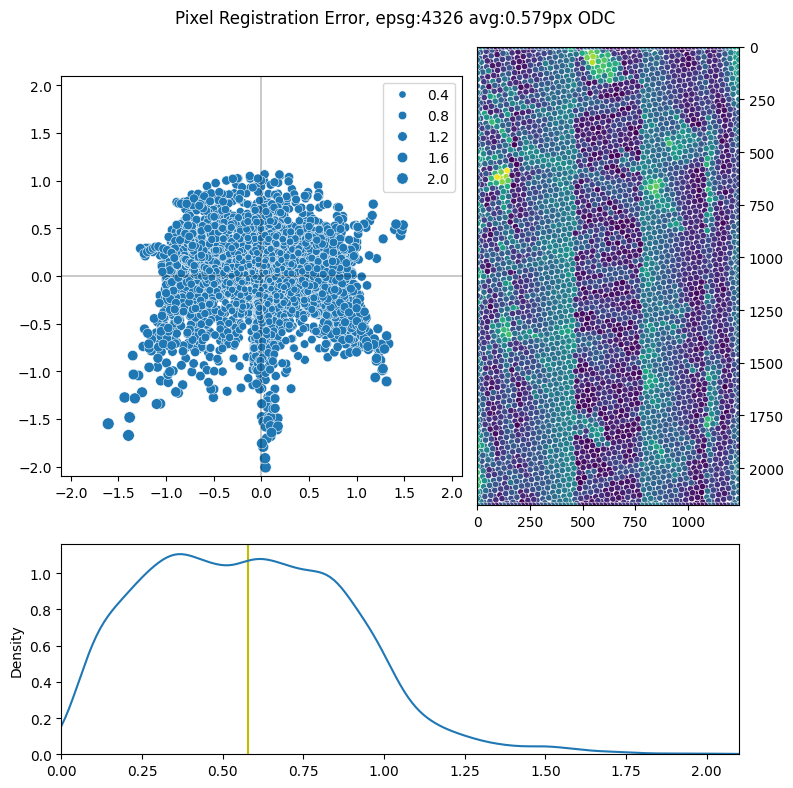

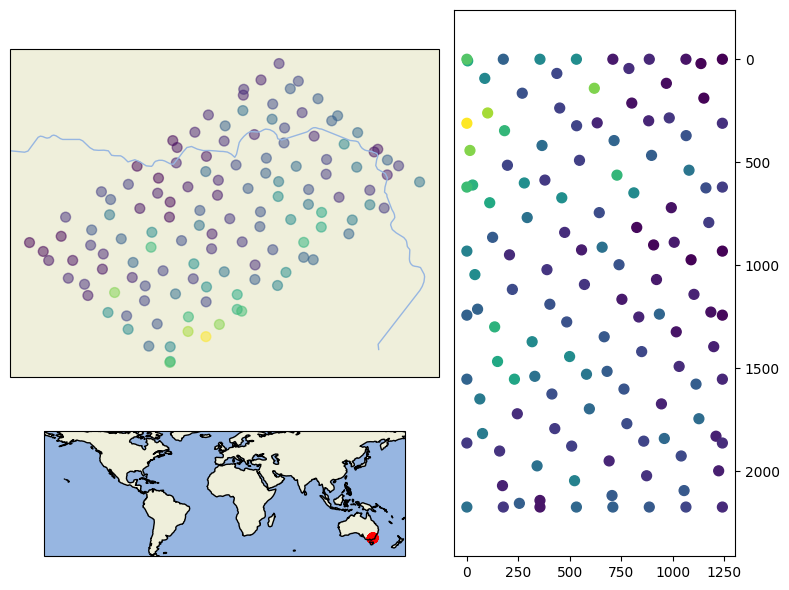

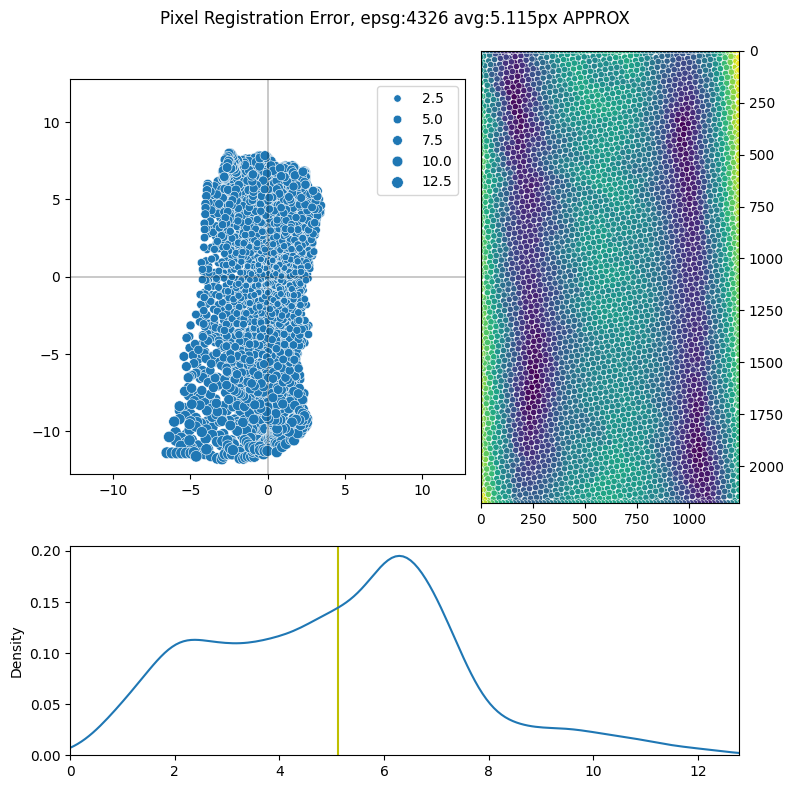

In [4]:
_sample = sub_sample(sample, 100, nside=7)
# _sample = sub_sample(sample, 1000, nside=30)
#_sample = sub_sample(sample, 50, nside=7)

gbox = gcp_geobox(_sample)
rio_gcp_tr = rio_gcp_transformer(_sample)

err_max = 2.1

rr1 = mk_error_plot(compute_error(sample, rio_gcp_tr), max_err_axis=err_max, msg="RIO")
rr2 = mk_error_plot(compute_error(sample, gbox), max_err_axis=err_max, msg="ODC")
_ = review_sample(_sample)
rr3 = mk_error_plot(compute_error(sample, gbox.approx), msg="APPROX")

In [5]:
rr1.ee.std(0), rr2.ee.std(0), rr3.ee.std(0)

(array([0.5303411 , 0.39948313]),
 array([0.51891519, 0.40121898]),
 array([1.74948273, 5.26015962]))

### GCP Error Analysis: sub-image

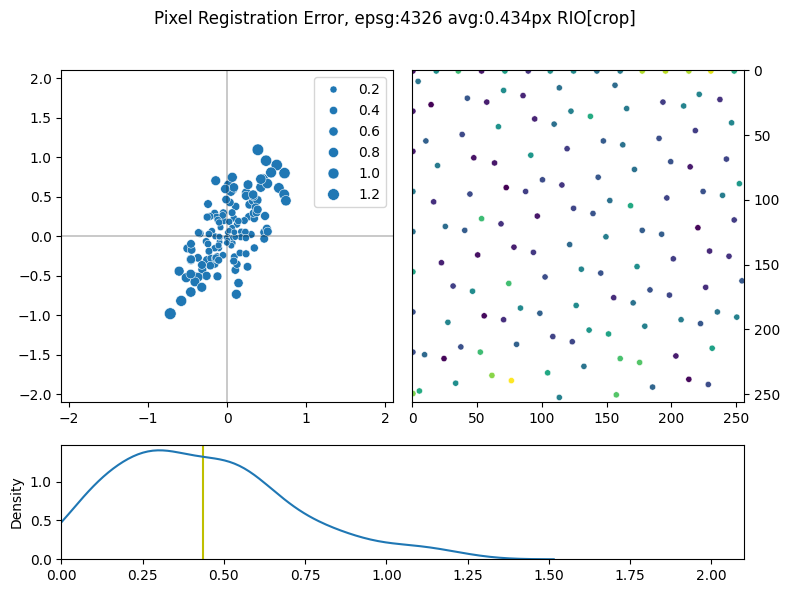

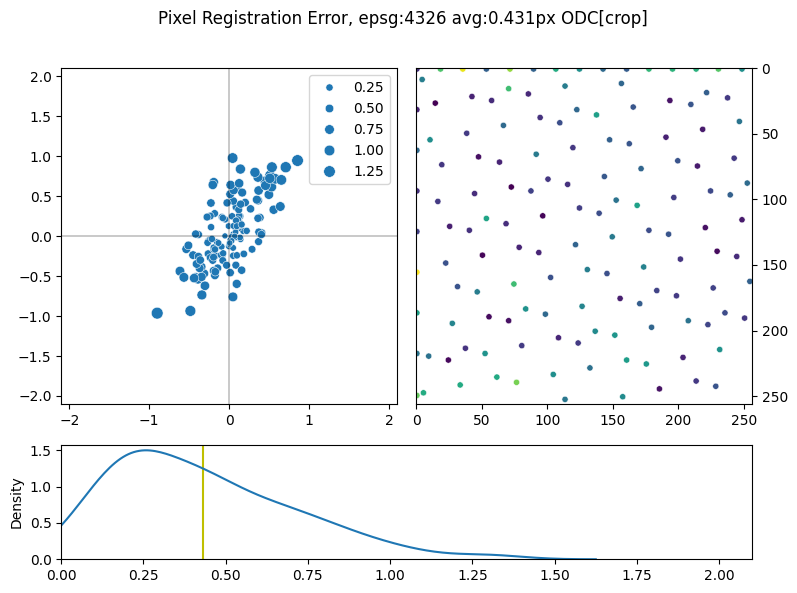

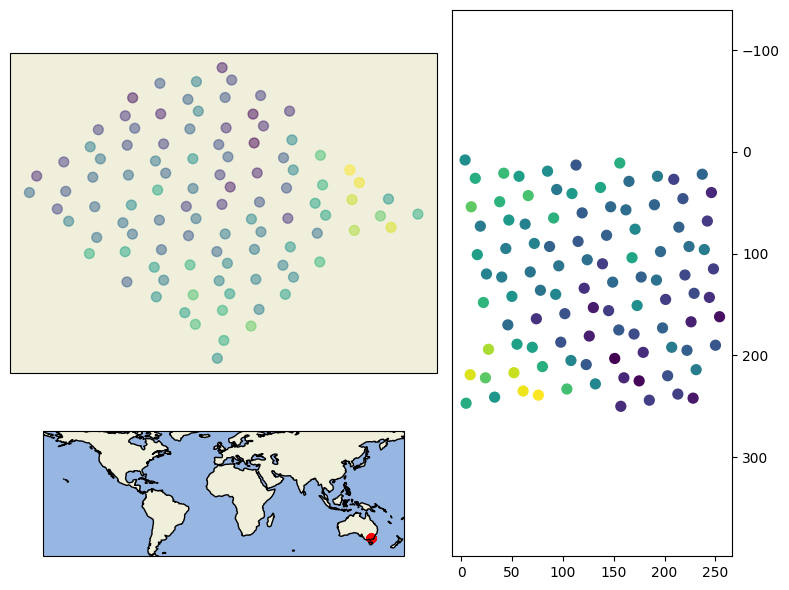

In [6]:
xx = to_pandas(sample)
ny, nx = 256, 256 # sample["shape"][1]

_xx = xx[(xx.row < ny) * (xx.col < nx)]
cropped_sample = {
    "id": xx.attrs["id"] + "_cropped",
    "shape": (ny, nx),
    **{k: v.tolist() for k, v in _xx.items()},
}

_csample = sub_sample(cropped_sample, 100)
gbox = gcp_geobox(_csample)
rio_gcp_tr = rio_gcp_transformer(_csample)

err_max = 2.1

rr1 = mk_error_plot(
    compute_error(cropped_sample, rio_gcp_tr), max_err_axis=err_max, msg="RIO[crop]"
)
rr2 = mk_error_plot(
    compute_error(cropped_sample, gbox), max_err_axis=err_max, msg="ODC[crop]"
)
fig, ax = review_sample(_csample)

In [7]:
rr1.ee.std(0), rr2.ee.std(0)

(array([0.30436706, 0.40201115]), array([0.29876431, 0.40957943]))

### GDAL GCP with Z

In [8]:
from utils.gcps import extract_rio_gcps
from rasterio.transform import GCPTransformer

gcps = extract_rio_gcps(_sample, skip_z=False)
display(len(gcps), gcps[:3])
tr = GCPTransformer(gcps)
x0, y0 = tr.xy(0, 0)
[(tr.rowcol(x0, y0+0.01, zs=z, op=lambda x: x), z) for z in [None, 0, 100, 1000]]

128

[GroundControlPoint(row=8, col=4, x=147.0419946543633, y=-37.019195851934796, z=1114.3204770483298, id='0'),
 GroundControlPoint(row=1238, col=935, x=147.20595947596036, y=-36.1421783359029, z=676.4233874588211, id='1'),
 GroundControlPoint(row=309, col=633, x=146.86644334491316, y=-36.631445934385965, z=336.17902690465667, id='2')]

[((13.18548917897349, 12.880593431421076), None),
 ((13.18548917897349, 12.880593431421076), 0),
 ((13.18548917897349, 12.880593431421076), 100),
 ((13.18548917897349, 12.880593431421076), 1000)]

In [9]:
gcps = extract_rio_gcps(_sample, skip_z=True)
display(len(gcps), gcps[:3])
tr = GCPTransformer(gcps)
x0, y0 = tr.xy(0, 0)
[(tr.rowcol(x0, y0+0.01, zs=z, op=lambda x: x), z) for z in [None, 0, 100, 1000]]

128

[GroundControlPoint(row=8, col=4, x=147.0419946543633, y=-37.019195851934796, id='0'),
 GroundControlPoint(row=1238, col=935, x=147.20595947596036, y=-36.1421783359029, id='1'),
 GroundControlPoint(row=309, col=633, x=146.86644334491316, y=-36.631445934385965, id='2')]

[((13.18548917897349, 12.880593431421076), None),
 ((13.18548917897349, 12.880593431421076), 0),
 ((13.18548917897349, 12.880593431421076), 100),
 ((13.18548917897349, 12.880593431421076), 1000)]

----------------------------------------------